In [1]:
!pip install yfinance stable-baselines3 ta gymnasium pyyaml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.6 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f2d208d1555f1e6063701d90e9e9abcf0737ff3dd15e93c332296a8755c67a7a
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import ta
import yaml

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
START_DATE = "2010-01-01"
END_DATE = "2019-12-31"

INITIAL_CASH = 1_000_000
TRANSACTION_COST = 0.001  # 0.1%

TRAIN_SPLIT = "2018-01-01"

In [4]:
TICKERS = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "HINDUNILVR.NS", "SBIN.NS", "ITC.NS", "LT.NS", "AXISBANK.NS",
    "KOTAKBANK.NS", "ASIANPAINT.NS", "BAJFINANCE.NS", "HCLTECH.NS",
    "MARUTI.NS", "SUNPHARMA.NS", "TITAN.NS", "WIPRO.NS", "ULTRACEMCO.NS",
    "NESTLEIND.NS", "POWERGRID.NS", "NTPC.NS", "ONGC.NS", "COALINDIA.NS",
    "TECHM.NS", "ADANIPORTS.NS", "BAJAJFINSV.NS", "JSWSTEEL.NS",
    "TATASTEEL.NS", "INDUSINDBK.NS", "DRREDDY.NS", "DIVISLAB.NS",
    "CIPLA.NS", "BPCL.NS", "GRASIM.NS", "HINDALCO.NS",
    "EICHERMOT.NS", "BRITANNIA.NS", "HEROMOTOCO.NS", "UPL.NS"
]

STOCK_DIM = len(TICKERS)
print("Number of stocks:", STOCK_DIM)

Number of stocks: 40


In [5]:
def download_stock_data(tickers, start, end):
    all_data = []

    for ticker in tickers:
        df = yf.download(
            ticker,
            start=start,
            end=end,
            progress=False
        )

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        df = df.reset_index()

        df["ticker"] = ticker

        df = df[["Date", "Open", "High", "Low", "Close", "Volume", "ticker"]]

        all_data.append(df)

    result = pd.concat(all_data, ignore_index=True)
    return result

In [6]:
TICKERS = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "HINDUNILVR.NS", "SBIN.NS", "ITC.NS", "LT.NS", "AXISBANK.NS",
    "KOTAKBANK.NS", "ASIANPAINT.NS", "BAJFINANCE.NS", "HCLTECH.NS",
    "MARUTI.NS", "SUNPHARMA.NS", "TITAN.NS", "WIPRO.NS", "ULTRACEMCO.NS",
    "NESTLEIND.NS", "POWERGRID.NS", "NTPC.NS", "ONGC.NS", "COALINDIA.NS",
    "TECHM.NS", "ADANIPORTS.NS", "BAJAJFINSV.NS", "JSWSTEEL.NS",
    "TATASTEEL.NS", "INDUSINDBK.NS", "DRREDDY.NS", "DIVISLAB.NS",
    "CIPLA.NS", "BPCL.NS", "GRASIM.NS", "HINDALCO.NS",
    "EICHERMOT.NS", "BRITANNIA.NS", "HEROMOTOCO.NS", "UPL.NS"
]

raw_data = download_stock_data(TICKERS, START_DATE, END_DATE)
raw_data.columns.name = None
print(raw_data.head(10))
print(raw_data.tail(10))

/tmp/ipython-input-1170703562.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-1170703562.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-1170703562.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  r

        Date        Open        High         Low       Close     Volume  \
0 2010-01-04  221.763765  221.763765  207.688857  218.593094   76646086   
1 2010-01-05  233.714740  233.714740  216.540283  217.617493   21392825   
2 2010-01-06  219.487382  222.454812  217.607339  221.133698   23691760   
3 2010-01-07  221.133708  226.621393  219.101219  224.802322   26197920   
4 2010-01-08  225.198688  226.377533  222.759715  224.212936   15110149   
5 2010-01-11  230.625353  233.674093  213.410274  219.812576  188649642   
6 2010-01-12  222.556442  231.153827  218.897976  220.391846   32790509   
7 2010-01-13  221.133716  221.946698  217.190697  221.255661   15360176   
8 2010-01-14  220.727195  228.613205  220.727195  227.983154   24545629   
9 2010-01-15  228.816428  231.478980  224.599046  225.757553   18766617   

        ticker  
0  RELIANCE.NS  
1  RELIANCE.NS  
2  RELIANCE.NS  
3  RELIANCE.NS  
4  RELIANCE.NS  
5  RELIANCE.NS  
6  RELIANCE.NS  
7  RELIANCE.NS  
8  RELIANCE.NS  
9  R

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
# Required column subset
raw_data = raw_data[["Date", "ticker", "Open", "High", "Low", "Close", "Volume"]]

# Initial consistent sort
raw_data = raw_data.sort_values(["ticker", "Date"])

# Per-stock forward fill
raw_data = (
    raw_data
    .groupby("ticker", as_index=False)
    .apply(lambda g: g.ffill())
    .reset_index(drop=True)
)

# Residual NaN removal
raw_data = raw_data.dropna()

# Date alignment logic

# Per-ticker date sets
date_sets = raw_data.groupby("ticker")["Date"].apply(set)

# Common date intersection
common_dates = set.intersection(*date_sets)

# Common date filtering
raw_data = raw_data[raw_data["Date"].isin(common_dates)]

# Final chronological ordering
raw_data = raw_data.sort_values(["Date", "ticker"]).reset_index(drop=True)

# Data consistency validation

dates_per_stock = raw_data.groupby("ticker")["Date"].nunique()
print("Min dates:", dates_per_stock.min())
print("Max dates:", dates_per_stock.max())

date_sets_after = raw_data.groupby("ticker")["Date"].apply(set)

# Date alignment verification
all_same_dates = all(s == date_sets_after.iloc[0] for s in date_sets_after)
print("All stocks share identical dates:", all_same_dates)


# Critical column check
assert "ticker" in raw_data.columns, "ticker column was lost!"

/tmp/ipython-input-4224814158.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.ffill())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Min dates: 2250
Max dates: 2250
All stocks share identical dates: True


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
print(raw_data.columns)
print(raw_data.head())

Index(['Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
        Date         ticker        Open        High         Low       Close  \
0 2010-11-04  ADANIPORTS.NS  148.159582  150.000073  147.515412  148.343628   
1 2010-11-04  ASIANPAINT.NS  236.773762  239.488847  232.470859  233.615662   
2 2010-11-04    AXISBANK.NS  285.169855  286.052555  282.852728  284.011292   
3 2010-11-04  BAJAJFINSV.NS   46.666135   47.237361   45.998094   46.661293   
4 2010-11-04  BAJFINANCE.NS    7.015980    7.250889    7.015980    7.237491   

    Volume  
0   835546  
1  1016060  
2  2665910  
3   170469  
4  1701659  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
print(raw_data.columns)
print("Index name:", raw_data.index.name)

Index(['Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index name: None


In [10]:
raw_data["return"] = raw_data.groupby("ticker")["Close"].pct_change()
raw_data = raw_data.dropna()
raw_data = raw_data.reset_index(drop=True)
raw_data.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Date,ticker,Open,High,Low,Close,Volume,return
0,2010-11-08,ADANIPORTS.NS,149.540002,150.414233,147.423433,148.527725,613082,0.001241
1,2010-11-08,ASIANPAINT.NS,235.716723,241.480227,235.716723,240.440689,575620,0.029215
2,2010-11-08,AXISBANK.NS,286.696207,291.293645,282.944710,286.126129,6482605,0.007446
3,2010-11-08,BAJAJFINSV.NS,47.731127,47.731127,45.988406,46.646767,199325,-0.000311
4,2010-11-08,BAJFINANCE.NS,7.252227,7.297333,7.159336,7.227218,1366226,-0.001419


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
print(raw_data["Date"].min())
print(raw_data["Date"].max())
raw_data.groupby("Date")["ticker"].nunique().head()

2010-11-08 00:00:00
2019-12-30 00:00:00


,ticker
Date,
2010-11-08,40
2010-11-09,40
2010-11-10,40
2010-11-11,40
2010-11-12,40


In [12]:
def add_technical_indicators(df):
    df = df.copy()

    macd_indicator = ta.trend.MACD(
        close=df["Close"],
        window_fast=12,
        window_slow=26,
        window_sign=9
    )

    df["macd"] = macd_indicator.macd()
    df["rsi"] = ta.momentum.rsi(df["Close"], window=14)
    df["cci"] = ta.trend.cci(df["High"], df["Low"], df["Close"], window=14)
    df["adx"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=14)

    return df

data = (raw_data.groupby("ticker", group_keys=False).apply(add_technical_indicators).dropna().reset_index(drop=True))
print(data.head())

        Date         ticker        Open        High         Low       Close  \
0 2010-12-14  ADANIPORTS.NS  138.957123  142.039952  137.070616  139.371231   
1 2010-12-14  ASIANPAINT.NS  236.703621  241.006524  236.703621  240.449463   
2 2010-12-14    AXISBANK.NS  245.282507  245.484795  236.345087  239.682831   
3 2010-12-14  BAJAJFINSV.NS   44.531303   44.632960   44.163395   44.323143   
4 2010-12-14  BAJFINANCE.NS    6.288033    6.338945    6.100464    6.301431   

     Volume    return      macd        rsi         cci  adx  
0    661078  0.021585 -2.047633  53.114320   94.971202  0.0  
1    254230  0.016202  0.128800  59.946139  121.302892  0.0  
2  12568445 -0.013100 -9.651177  37.960756  -58.697456  0.0  
3   6473861 -0.003049 -0.286268  38.194769  -61.427179  0.0  
4    588319  0.009805 -0.237700  40.393838  -11.355846  0.0  


/tmp/ipython-input-2410796062.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = (raw_data.groupby("ticker", group_keys=False).apply(add_technical_indicators).dropna().reset_index(drop=True))
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
# Pivot matrix: Date x Stock
returns_pivot = data.pivot(index="Date", columns="ticker", values="return")
returns_pivot = returns_pivot.dropna()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
def compute_turbulence(returns_df, window=252):
    turbulence = []

    for i in range(len(returns_df)):
        if i < window:
            turbulence.append(0)
            continue

        current_return = returns_df.iloc[i].values
        historical_returns = returns_df.iloc[i - window:i]

        cov = np.cov(historical_returns.T)
        cov_inv = np.linalg.pinv(cov)

        mean = historical_returns.mean().values
        diff = current_return - mean

        turbulence_value = diff.T @ cov_inv @ diff
        turbulence.append(turbulence_value)

    return pd.Series(turbulence, index=returns_df.index)

In [15]:
turbulence_series = compute_turbulence(returns_pivot)
data = data.merge(turbulence_series.rename("turbulence"), left_on="Date", right_index=True)
data = data.reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
train_data = data[data["Date"] < TRAIN_SPLIT]
test_data = data[data["Date"] >= TRAIN_SPLIT]

print("Train dates:", train_data["Date"].min(), "→", train_data["Date"].max())
print("Test dates:", test_data["Date"].min(), "→", test_data["Date"].max())

Train dates: 2010-12-14 00:00:00 → 2017-12-29 00:00:00
Test dates: 2018-01-01 00:00:00 → 2019-12-30 00:00:00


In [18]:
train_data.to_csv("train_data_RL_final_submission.csv", index=False)
test_data.to_csv("test_data_RL_final_submission.csv", index=False)

In [ ]:
%%writefile hyperparameters.yml
env:
  initial_cash: 1000000
  transaction_cost_pct: 0.001
  turbulence_quantile: 0.95

ppo:
  policy: "MlpPolicy"
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  gamma: 0.99
  gae_lambda: 0.95
  ent_coef: 0.0
  vf_coef: 0.5
  clip_range: 0.2
  max_grad_norm: 0.5
  total_timesteps: 500000

Writing hyperparameters.yml


In [ ]:
import yaml
with open("hyperparameters.yml", "r") as f:
    config = yaml.safe_load(f)
config

{'env': {'initial_cash': 1000000,
  'transaction_cost_pct': 0.001,
  'turbulence_quantile': 0.95},
 'ppo': {'policy': 'MlpPolicy',
  'learning_rate': 0.0003,
  'n_steps': 2048,
  'batch_size': 64,
  'gamma': 0.99,
  'gae_lambda': 0.95,
  'ent_coef': 0.0,
  'vf_coef': 0.5,
  'clip_range': 0.2,
  'max_grad_norm': 0.5,
  'total_timesteps': 500000}}

In [ ]:
TURBULENCE_THRESHOLD = data["turbulence"].quantile(config["env"]["turbulence_quantile"])
print("Turbulence threshold:", TURBULENCE_THRESHOLD)

Turbulence threshold: 98.30469266126096


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df,
        initial_cash,
        transaction_cost_pct,
        turbulence_threshold=None,
        hmax=1000
    ):
        super().__init__()

        # Environment configuration parameters
        self.df = df
        self.initial_cash = initial_cash
        self.transaction_cost_pct = transaction_cost_pct
        self.turbulence_threshold = turbulence_threshold
        self.hmax = hmax
        # Market metadata setup
        self.dates = sorted(df["Date"].unique())
        self.tickers = sorted(df["ticker"].unique())
        self.n_stocks = len(self.tickers)

        # Continuous action definition
        # Normalized stock actions
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self.n_stocks,),
            dtype=np.float32
        )

        # State space definition
        # Cash and technical indicators
        obs_dim = 1 + self.n_stocks * 6
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(obs_dim,),
            dtype=np.float32
        )

        # Initial state reset
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.cash = self.initial_cash
        self.holdings = np.zeros(self.n_stocks, dtype=np.float32)

        obs = self._get_observation()
        info = {}

        return obs, info

    def _get_observation(self):
        date = self.dates[self.current_step]
        day = self.df[self.df["Date"] == date]

        prices = day["Close"].values
        macd = day["macd"].values
        rsi = day["rsi"].values
        cci = day["cci"].values
        adx = day["adx"].values

        obs = np.concatenate([
            np.array([self.cash], dtype=np.float32),
            prices,
            self.holdings,
            macd,
            rsi,
            cci,
            adx
        ])

        return obs.astype(np.float32)

    def step(self, action):
        date = self.dates[self.current_step]
        day = self.df[self.df["Date"] == date]

        prices = day["Close"].values
        turbulence = day["turbulence"].iloc[0]

        portfolio_value_before = self.cash + np.sum(self.holdings * prices)

        # Market turbulence logic
        if (
            self.turbulence_threshold is not None
            and turbulence > self.turbulence_threshold
        ):
            # Liquidation on instability
            sell_value = np.sum(self.holdings * prices)
            cost = sell_value * self.transaction_cost_pct
            self.cash += sell_value - cost
            self.holdings[:] = 0

        else:
            # Standard trading execution
            for i in range(self.n_stocks):
                price = prices[i]
                act = action[i]

                if act > 0:  # Long position entry
                    max_shares = min(self.hmax, self.cash // price)
                    shares = int(max_shares * act)
                    cost = shares * price * (1 + self.transaction_cost_pct)

                    if cost <= self.cash:
                        self.cash -= cost
                        self.holdings[i] += shares

                elif act < 0:  # Position reduction
                    shares = int(self.holdings[i] * (-act))
                    revenue = shares * price
                    cost = revenue * self.transaction_cost_pct

                    self.cash += revenue - cost
                    self.holdings[i] -= shares

        # Time step increment
        self.current_step += 1
        done = self.current_step >= len(self.dates) - 1

        portfolio_value_after = self.cash + np.sum(self.holdings * prices)
        reward = (portfolio_value_after - portfolio_value_before)/portfolio_value_before

        obs = self._get_observation()
        info = {}

        return obs, reward, done, False, info

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv

# Sanity check raw environment
env = TradingEnv(
    train_data,
    initial_cash=config["env"]["initial_cash"],
    transaction_cost_pct=config["env"]["transaction_cost_pct"],
    turbulence_threshold=TURBULENCE_THRESHOLD
)

obs, info = env.reset()
print("Raw env obs shape:", obs.shape, "info type:", type(info))

# Vectorized training environment
train_env = DummyVecEnv([
    lambda: TradingEnv(
        train_data,
        initial_cash=config["env"]["initial_cash"],
        transaction_cost_pct=config["env"]["transaction_cost_pct"],
        turbulence_threshold=TURBULENCE_THRESHOLD
    )
])

# Vectorized test environment
test_env = DummyVecEnv([
    lambda: TradingEnv(
        test_data,
        initial_cash=config["env"]["initial_cash"],
        transaction_cost_pct=config["env"]["transaction_cost_pct"],
        turbulence_threshold=TURBULENCE_THRESHOLD
    )
])

Raw env obs shape: (241,) info type: <class 'dict'>


In [ ]:
model = PPO(
    policy=config["ppo"]["policy"],
    env=train_env,
    learning_rate=config["ppo"]["learning_rate"],
    n_steps=config["ppo"]["n_steps"],
    batch_size=config["ppo"]["batch_size"],
    gamma=config["ppo"]["gamma"],
    gae_lambda=config["ppo"]["gae_lambda"],
    ent_coef=config["ppo"]["ent_coef"],
    vf_coef=config["ppo"]["vf_coef"],
    clip_range=config["ppo"]["clip_range"],
    max_grad_norm=config["ppo"]["max_grad_norm"],
    verbose=1
)

Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, print_freq=10_000, verbose=1):
        super().__init__(verbose)
        self.print_freq = print_freq
        self.rewards = []

    def _on_step(self) -> bool:
        # self.locals contains rollout data
        if "rewards" in self.locals:
            self.rewards.append(self.locals["rewards"][0])

        if self.n_calls % self.print_freq == 0:
            mean_reward = np.mean(self.rewards[-1000:]) if len(self.rewards) > 0 else 0
            print(f"Step {self.n_calls} | Mean reward (last 1000 steps): {mean_reward:.2f}")

        return True

In [ ]:
class PortfolioValueCallback(BaseCallback):
    def __init__(self, print_freq=10_000, verbose=1):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        env = self.training_env.envs[0]
        prices = env.df[env.df["Date"] == env.dates[env.current_step]]["Close"].values
        portfolio_value = env.cash + np.sum(env.holdings * prices)

        if self.n_calls % 10_000 == 0:
            print(f"Step {self.n_calls} | Portfolio value: {portfolio_value:.2f}")

        return True

In [ ]:
callback = PortfolioValueCallback()

model.learn(
    total_timesteps=config["ppo"]["total_timesteps"],
    callback=callback
)

-----------------------------
| time/              |      |
|    fps             | 302  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 262         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.030722842 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.8       |
|    explained_variance   | -24.6       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0441     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0524     |
|    std                  | 1           |
|    value_loss           | 0.0884      |
----------------------------------

In [ ]:
model.save("/content/ppo_trading_model_final")

In [ ]:
from google.colab import files
files.download("/content/ppo_trading_model_final.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate_model(model, test_env):
    obs = test_env.reset()
    env = test_env.envs[0]

    portfolio_values = []

    for _ in range(len(env.dates)-1):
      # NOTE:
      # We iterate only till len(dates) - 1 because calling env.step() on the last
      # tradable day would return done=True, which causes DummyVecEnv to immediately
      # auto-reset the environment. If we then try to log the portfolio value after
      # that step, we would incorrectly record the reset (day 0) portfolio instead
      # of the true final trading-day portfolio.

        # Value Computation before stepping
        prices = env.df[
            env.df["Date"] == env.dates[env.current_step]
        ]["Close"].values

        value = env.cash + np.sum(env.holdings * prices)
        portfolio_values.append(value)

        # Action
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = test_env.step(action)

        if done:
            break

    portfolio_values = np.array(portfolio_values)

    # Cumulative Return
    cumulative_return = (
        (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
        if len(portfolio_values) > 1 else 0.0
    )

    # Sharpe Ratio
    returns = pd.Series(portfolio_values).pct_change().dropna()
    sharpe = (
        np.sqrt(252) * returns.mean() / returns.std()
        if returns.std() != 0 else 0.0
    )

    return portfolio_values, cumulative_return, sharpe
portfolio_values, cum_ret, sharpe = evaluate_model(model, test_env)

In [ ]:
num_runs = 3
all_results = []

for i in range(num_runs):
    portfolio_values, cum_ret, sharpe = evaluate_model(model, test_env)
    all_results.append((portfolio_values, sharpe))

    print(f"Run {i+1} | Cumulative Return: {cum_ret*100:.2f}% | Sharpe Ratio: {sharpe:.3f}")

Run 1 | Cumulative Return: 82.77% | Sharpe Ratio: 1.600
Run 2 | Cumulative Return: 82.77% | Sharpe Ratio: 1.600
Run 3 | Cumulative Return: 82.77% | Sharpe Ratio: 1.600


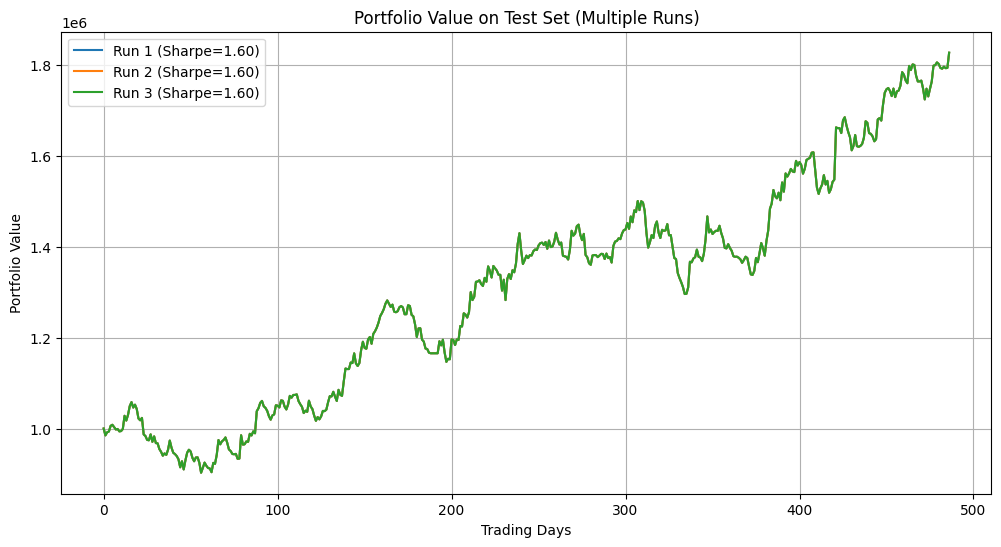

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for i, (portfolio_values, sharpe) in enumerate(all_results):
    plt.plot(portfolio_values, label=f"Run {i+1} (Sharpe={sharpe:.2f})")


plt.title("Portfolio Value on Test Set (Multiple Runs)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()